# Classifying Humans and Robots on an Auction Site using Gradient Boosted Decision Trees

This is my submission to the Kaggle competition "Facebook Recruiting IV: Human or Robot?". Feature engineering is the main challenge behind the competition. The data given somewhat resembles the raw data you would be able to collect working in the industry: there's a lot of it and it's messy. 

We are given three data sets to base our machine learning model around. The first two being a training and test set of bidders with their IDs and obfuscated payment account numbers and addresses as well as their classification (for the training set only). The third data set holds the bids and bid information of each bidder. This includes the auction a bid was made in, the merchandise page a bidder entered the site through, the device, country, and IP a bid was entered from, and the URL the bidder was referred from.

The first two data sets each have a few thousand entries in them while the bids data set has more than seven and half million entries in it. Since we are classifying bidders and not bids, we will have to use aggregate functions to engineer feature values from the bids dataset to then assign to each bidder.

Let's import the libraries we will need and load the three data sets with the bids data set being sorted out in the chronological order of bidding. 

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gc

%matplotlib notebook

df_train = pd.read_csv('train.csv', index_col= 'bidder_id')
df_test = pd.read_csv('test.csv', index_col= 'bidder_id')
df_bids = pd.read_csv('bids.csv').sort_values('time', ascending= True)

### Feature Engineering

Here's a look at our bids data set.

In [2]:
df_bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
2351187,2351187,76218e14c379c12d599dae9e1c00b61a3i5b2,6hpvy,sporting goods,phone1161,9631916842105263,cz,121.169.96.51,f33fl83l4vrg6is
2351202,2351202,29c103503e1d6ace5626fb07a5ab0dafrtjvs,wpee4,jewelry,phone412,9631916842105263,ru,63.82.37.102,via8q041tf3xrke
2351201,2351201,0ea62aaa9c3ffcc6db584cb69c1f6c4bcripp,b6zck,mobile,phone99,9631916842105263,lt,181.144.42.116,vasstdc27m7nks3
2351200,2351200,6e178db6d17d21aa88aaca5bf15c2761lc500,jqx39,jewelry,phone99,9631916842105263,sa,174.12.78.255,omwhmwzvrn6ycq6
2351199,2351199,b7c4f67613c2af7e544f01359d4fccc7l5f7y,du967,office equipment,phone348,9631916842105263,tr,21.10.208.37,vasstdc27m7nks3


It appears that we'll mostly be working with categorical data. Time is the only continuous variable, taking the form of a Unix timestamp in microseconds. There's plenty of information that we could extract from this without needing to reformat the variable. 

Let's construct a few hypotheses on how we could detect robot bidders using our data:

Bots can bid at an inhuman rate. In particular, they could react to other bids at an inhuman rate.

Bots would tend to be more active than human bidders.

Bots may enter auctions at a predictable point apart from most humans. Possibly either later on in the auction to "steal" the auction and win without driving the price too high or early on due to an automated alerts to newly created auctions.

Bots may tend to carry an IP masked with VPN or Proxy software, resulting in more unique IPs or listed countries than the average user.

Certain countries with higher instances of cybercrime than the average country may be common origin points for bots. 

It's important to keep in mind that we could underestimate human bidders. There are definitely human bidders that are very active on the site, bid at an increadible rate and mask their IPs. We have a good variety of features from which the algorithm we train will use to detect patterns that differentiate these users from bots. Tuning our algorithm's hyperparameters using cross validation with Area under the curve (AUC) as the metric for score will also help as AUC takes into consideration true positives and true negatives rather than simply computing overall accuracy. This is especially important as the humans outnumber bots at about 20:1 in the training set.

We'll be creating three major feature classes: Amount of unique values per categorical variable, counts of specific unique categories, and time-based features. For ease of reference, I will refer to these feature sets respectively as our "Unique", "Categories", and "Time" feature sets.

Let's start with the simplest one to write, the Unique feature set.

In [3]:
# Check for categorical variables with null values.
df_bids.columns[df_bids.isnull().values.any(axis= 0)].tolist()

['country']

In [4]:
# Replace null values with a category recognizable by our algorithm.
df_bids['country'] = df_bids['country'].fillna('n/a')

In [5]:
# Count the amount of unique values per categorical variable and arrange into a feature set. 
unique = df_bids.groupby('bidder_id').size().to_frame('bids')

for column in ['auction', 'merchandise', 'device', 'country', 'ip', 'url']:
    
    unique['unique_' + column] = df_bids.groupby('bidder_id')[column].apply(lambda x: len(x.unique()))

# List column names for reference when plotting.
unique_columns = unique.columns.tolist()

Notice that we are creating features based on variables not mentioned in our hypothesis. We are trying to extract any extra information that we could think to improve our classifier algorithm. Since we'll be using a decision trees algorithm, the algorithm will be considering several features at a time in each decision tree that it creates. 

For example: Many bots and several humans have made over a thousand bids, but these bots have also spread these bids out accross more auctions.

Now, we create the Categories feature set. We will be using the country and merchandise categorical variables only to save on memory as we are using the Pandas library which could be rather resource-hungry at times.

In [6]:
# Create dummy variables to replace categorical variables.
def add_dummies(df, col):
    dummies = pd.get_dummies(df[col])
    df = pd.concat([df, dummies], axis= 1)
        
    return df
    
for column in ['country', 'merchandise']:
    df_bids = add_dummies(df_bids, column)
    
categories = df_bids.groupby('bidder_id')[df_bids.columns[9:]].sum()

# List column names for reference when plotting.
categories_columns_country = df_bids['country'].unique().tolist()
categories_columns_merchandise = df_bids['merchandise'].unique().tolist()

Now for the Time features. This will be our most sophisticated feature set as I hypothesize that these variable will be the most helpful in classifying robots apart from humans. We begin by writing a function that applies several aggregate functions to our time data to draw relevant metrics from each type of feature we will be creating.

In [7]:
def aggs(df, group, column, tag, impute= True):
    
    result = df.groupby(group)[column].agg([np.min, np.max, np.mean, pd.DataFrame.mad])
    result = result.rename(columns= {result.columns[0]: tag + '_min', result.columns[1]: tag + '_max'
                                    ,result.columns[2]: tag + '_mean', result.columns[3]: tag + '_mad'})
    
    if impute:
        result = result.fillna(result.mean())
    
    return result

In [8]:
# Get time difference between each bid for each bidder.
df_bids['bid_time_diff'] = df_bids.groupby('bidder_id')['time'].diff()

# Get aggregates for time difference between each bid for each bidder.
bid_time_diff_aggs = aggs(df_bids, 'bidder_id', 'bid_time_diff', 'bid_time_diff')


# Get time between bids for each auction.
df_bids['reaction_time'] = df_bids.groupby('auction')['time'].diff()

# Get aggregates for reaction time to the last bid in an auction by each bidder across all auctions. 
reaction_time_aggs = aggs(df_bids, ['bidder_id', 'auction'], 'reaction_time', 'reaction_time')
reaction_time_aggs = pd.DataFrame(data= [reaction_time_aggs.groupby('bidder_id')['reaction_time_min'].min(),
                                         reaction_time_aggs.groupby('bidder_id')['reaction_time_max'].max(),
                                         reaction_time_aggs.groupby('bidder_id')['reaction_time_mean'].mean(),
                                         reaction_time_aggs.groupby('bidder_id')['reaction_time_mad'].mean()]).transpose()

# Get bidder entry time into each auction.
entry = pd.DataFrame(df_bids.groupby(['bidder_id', 'auction'])['time'].min()).reset_index()
entry = entry.rename(columns= {'time': 'entry'})

# Get auction midpoint time and auction length.
auction_time_aggs = pd.DataFrame((df_bids.groupby('auction')['time'].max() + df_bids.groupby('auction')['time'].min()) / 2)
auction_time_aggs['auction_length'] = df_bids.groupby('auction')['time'].max() - df_bids.groupby('auction')['time'].min()
auction_time_aggs = auction_time_aggs.rename(columns= {'time': 'auction_midpoint'}).reset_index()

# Merge data and get entry-midpoint distance metric.
entry = entry.merge(auction_time_aggs, how= 'left', on= 'auction')
# Normalize values by auction length.
entry['entry_midpoint_distance'] = (entry['entry'] - entry['auction_midpoint']) / entry['auction_length']
# Set value to upper scale limit for auctions with only one bid.
entry['entry_midpoint_distance'] = entry['entry_midpoint_distance'].fillna(0.50)

# Get aggregates for entry-midpoint distance metric for each bidder.
entry_midpoint_distance_aggs = aggs(entry, 'bidder_id', 'entry_midpoint_distance', 'entry_midpoint_distance')

# Get overall time spent by each bidder and mean time spent by each bidder on each auction participated in.
timeframe = pd.DataFrame(df_bids.groupby('bidder_id')['time'].max() - df_bids.groupby('bidder_id')['time'].min())
timeframe = timeframe.rename(columns= {'time': 'time_spent'})
timeframe['time_spent_auction_mean'] = (df_bids.groupby(['bidder_id', 'auction'])['time'].max() - 
                                        df_bids.groupby(['bidder_id', 'auction'])['time'].min()).groupby('bidder_id').mean()

# Get aggregates for bids sharing the same set number of left-most digits of time made by each bidder.
for character_limit in [4, 5, 6]:
    df_bids['time_partial_' + str(character_limit)] = df_bids['time'].astype(str).str.slice(0, character_limit)

time_match_4 = df_bids.groupby('bidder_id')['time_partial_4'].value_counts().to_frame('count')
time_match_4 = aggs(time_match_4, 'bidder_id', 'count', 'time_match_4')

time_match_5 = df_bids.groupby('bidder_id')['time_partial_5'].value_counts().to_frame('count')
time_match_5 = aggs(time_match_5, 'bidder_id', 'count', 'time_match_5')

time_match_6 = df_bids.groupby('bidder_id')['time_partial_6'].value_counts().to_frame('count')
time_match_6 = aggs(time_match_6, 'bidder_id', 'count', 'time_match_6')

time_match = time_match_4.join(time_match_5).join(time_match_6)

# Compile time aggregates
time_aggs = timeframe.join(bid_time_diff_aggs).join(reaction_time_aggs).join(entry_midpoint_distance_aggs).join(time_match)

# List column names for reference when plotting.
time_columns = time_aggs.columns.tolist()

That's our three feature sets. We now combine them into a single feature set then organize our data into our training and test sets.

In [5]:
features = unique.join(time_aggs).join(categories)
features.head()

,bids,unique_auction,unique_merchandise,unique_device,unique_country,unique_ip,unique_url,time_spent,time_spent_auction_mean,bid_time_diff_min,...,vc,ve,vi,vn,ws,ye,za,zm,zw,zz
bidder_id,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,0,0.000000e+00,1.388488e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002d229ffb247009810828f648afc2ef593rb,2,1,1,2,1,1,1,105263158,1.052632e+08,1.052632e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,0,0.000000e+00,1.388488e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,1,3,2,65955684210526,0.000000e+00,5.369263e+12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,1,10,7,76349842105263,1.518721e+12,3.684211e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Organize the data into training and test sets. Rows with null values in the training set are dropped as Facebook did not
# intend to include these rows in the data. Imputing values for these empty rows may also confuse the algorithm we write.
df_train = df_train.merge(features, how= 'left', left_index= True, right_index= True)
df_train = df_train.drop(columns= ['payment_account', 'address']).dropna()

X_train = df_train[df_train.columns[1:]]
y_train = df_train[df_train.columns[0]]

# Rows with null values in the test set are filled with zeros. Facebook will ignore our predictions for these rows as they were
# also not intended to be included in the data.
X_test = df_test.merge(features, how= 'left', left_index= True, right_index= True)
X_test = X_test.drop(columns= ['payment_account', 'address']).fillna(0)

In [11]:
# Free up memory 
for trash in [timeframe, bid_time_diff_aggs, reaction_time_aggs, entry, auction_time_aggs, 
              entry_midpoint_distance_aggs, time_match_4, time_match_5, time_match_6, time_match,
              unique, time_aggs, categories, df_train, df_test, df_bids]:
    del trash

gc.collect();

### Machine Learning

We will be applying a Gradient Boosted Decision Trees model on our data using the xgboost API. 

To tune the hyperparameters of the model, we will implement skopt's API for Bayesian Optimization with Gaussian Processes. This is a highly efficient method of hyperparameter tuning as the optimization algorithm maps out the hyperparameter space throughout each iteration to make a "smart" decision on what hyperparameters to choose in the next iteration. In this notebook, we will get close to the best roc score we could achieve in just five iterations. Having the optimization algorithm run for longer will continously return hyperparameters that result in minute increases in AUC score.

In [3]:
# Set the run length and random state of the optimization algorithm.
iterations = 10
seed = 50

# The base parameters to the xgboost classifier. This classifier is set to use GPU computing. You can disable this by setting
# tree method to 'hist' and the predictor to 'cpu_predictor'.
clf = xgb.XGBClassifier(tree_method= 'gpu_hist', predictor= 'gpu_predictor', objective= 'binary:logistic', 
                        eval_metric= 'auc', nthreads= 1, seed= seed)

# The hyperparameter space in which the optimization algorithm will search for the best set of hyperparameters to run the 
# xgboost model on.
parameter_grid = {'n_estimators': (500, 3000),
                  'learning_rate': (0.001, 1.0, 'log-uniform'),
                  'max_depth': (3, 10),
                  'min_child_weight': (0, 10),
                  'max_delta_step': (0, 10),
                  'subsample': (0.2, 1.0, 'uniform'),
                  'colsample_bytree': (0.8, 1.0, 'uniform'),
                  'colsample_bylevel': (0.8, 1.0, 'uniform'),
                  'reg_lambda': (1e-9, 1000, 'log-uniform'),
                  'reg_alpha': (1e-9, 1.0, 'log-uniform'),
                  'gamma': (1e-9, 0.5, 'log-uniform'),
                  'scale_pos_weight': (1e-6, 500, 'log-uniform')}

# Five cross validation folds are used at each iteration of the parameter search. The xgboost model is set to use a single CPU
# core while the optimization algorithm is set to use all available CPU cores in parallel.
cv_algorithm = BayesSearchCV(estimator= clf, search_spaces= parameter_grid, scoring= 'roc_auc',
                             cv= StratifiedKFold(n_splits= 5, shuffle= True, random_state= seed),
                             n_jobs= -1, n_iter= iterations, verbose= True, refit= True, random_state= seed)

# A callback function to return status reports at the end of each iteration of the parameter search.
def status_print(optim_result):
    
    cv_results = pd.DataFrame(cv_algorithm.cv_results_)    
       
    best_params = pd.Series(cv_algorithm.best_params_)
    print('Model #{}\nBest {}: {}\nBest params: {}\n'.format(len(cv_results),
                                                             cv_algorithm.scoring,
                                                             np.round(cv_algorithm.best_score_, 4),
                                                             cv_algorithm.best_params_))
    
    # Save results
    clf_name = cv_algorithm.estimator.__class__.__name__
    cv_results.to_csv(clf_name+'_cv_results.csv')

In [13]:
cv_algorithm = cv_algorithm.fit(X_train, y_train, callback= status_print)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.8s finished


Model #1
Best roc_auc: 0.5
Best params: {'colsample_bylevel': 0.9721979111667575, 'colsample_bytree': 0.8902432325584179, 'gamma': 2.2586662917224153e-05, 'learning_rate': 0.49358830548776716, 'max_delta_step': 1, 'max_depth': 6, 'min_child_weight': 8, 'n_estimators': 1461, 'reg_alpha': 1.1657129629938202e-09, 'reg_lambda': 0.00023255326346904284, 'scale_pos_weight': 0.0001214766155219951, 'subsample': 0.3313429699609568}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s finished


Model #2
Best roc_auc: 0.9242
Best params: {'colsample_bylevel': 0.9494356900082885, 'colsample_bytree': 0.9967267312494479, 'gamma': 0.05284097980919517, 'learning_rate': 0.06275790527395109, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 2633, 'reg_alpha': 0.0009472298205939399, 'reg_lambda': 1.7294639346491166e-09, 'scale_pos_weight': 2.66224521163096, 'subsample': 0.9138062497451529}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.8s finished


Model #3
Best roc_auc: 0.9242
Best params: {'colsample_bylevel': 0.9494356900082885, 'colsample_bytree': 0.9967267312494479, 'gamma': 0.05284097980919517, 'learning_rate': 0.06275790527395109, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 2633, 'reg_alpha': 0.0009472298205939399, 'reg_lambda': 1.7294639346491166e-09, 'scale_pos_weight': 2.66224521163096, 'subsample': 0.9138062497451529}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


Model #4
Best roc_auc: 0.9242
Best params: {'colsample_bylevel': 0.9494356900082885, 'colsample_bytree': 0.9967267312494479, 'gamma': 0.05284097980919517, 'learning_rate': 0.06275790527395109, 'max_delta_step': 2, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 2633, 'reg_alpha': 0.0009472298205939399, 'reg_lambda': 1.7294639346491166e-09, 'scale_pos_weight': 2.66224521163096, 'subsample': 0.9138062497451529}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Model #5
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


Model #6
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Model #7
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished


Model #8
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.4s finished


Model #9
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.3s finished


Model #10
Best roc_auc: 0.9366
Best params: {'colsample_bylevel': 0.8755339204052285, 'colsample_bytree': 0.8874046902319567, 'gamma': 2.7639230423064887e-08, 'learning_rate': 0.0023022828327372872, 'max_delta_step': 4, 'max_depth': 8, 'min_child_weight': 10, 'n_estimators': 2877, 'reg_alpha': 0.031092167242297245, 'reg_lambda': 0.00023042807395347575, 'scale_pos_weight': 4.727074877553192, 'subsample': 0.403561012166152}



The model we will use is one that I applied the optimization algorithm on for 100 iterations. We will make ten sets of predictions on the test data, changing only the random state each time, and average out these predictions to create our submission. This submission should score within the 0.91 to 0.94 ROC score range on the Kaggle leaderboard. 

In [8]:
clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree',
                        colsample_bylevel=0.9864826003058819, colsample_bytree=0.8,
                        eval_metric='auc', gamma=1e-09, learning_rate=0.06211647829948551,
                        max_delta_step=6, max_depth=6, min_child_weight=10, missing=None,
                        n_estimators=3000, n_jobs=1, nthread=None,
                        objective='binary:logistic', predictor='gpu_predictor',
                        random_state=0, reg_alpha=1e-09, reg_lambda=1000.0,
                        scale_pos_weight=7.785103235889749, seed=15, silent=True,
                        subsample=0.579939508959872, tree_method='gpu_hist')

# The classifier is set to use all available CPU cores in parallel.
clf.set_params(nthreads= -1)

models = 10
prediction_matrix = np.zeros((len(X_test), models))
feature_importance_matrix = np.zeros((len(X_train.columns), models))

# Average predictions and feature importance scores across each model.
for i in range(models):
    clf.set_params(seed= i + 1)
    clf.fit(X_train, y_train)
    prediction_matrix[:, i] = clf.predict_proba(X_test)[:, 1]
    feature_importance_matrix[:, i] = clf.feature_importances_
    
prediction_mean = prediction_matrix.mean(axis= 1)
X_test['prediction'] = prediction_mean

feature_importances = feature_importance_matrix.mean(axis= 1)
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': feature_importances}).set_index('feature')
feature_importances = feature_importances.sort_values(by= 'importance', ascending= False)

Let's plot the feature importances of the top 15 most important features entered into the model to understand how the model makes its predictions.

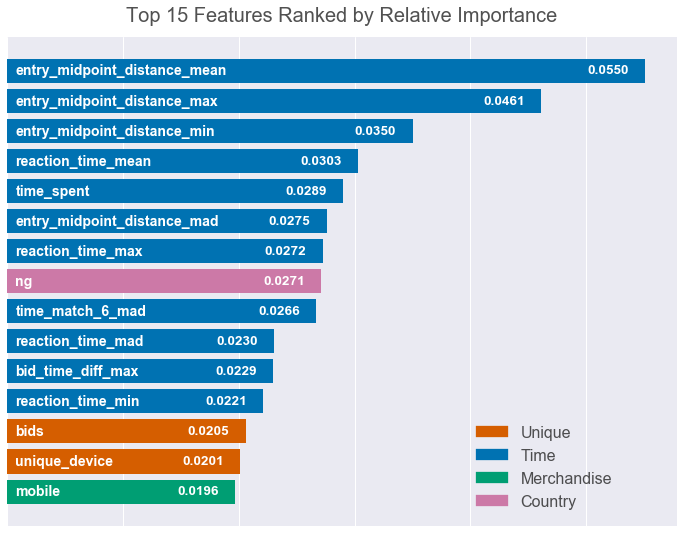

In [24]:
plt.style.use('seaborn')

fig = plt.figure(figsize=(12, 9))
ax = plt.gca()

plt.title('Top 15 Features Ranked by Relative Importance', fontsize= 20, pad= 15, alpha= 0.8)

# Set data points
n = 15
x = feature_importances.index[:n]
y = feature_importances['importance'][:n]

# We use the seaborn-colorblind style for bar colors and color the bars according to their 
# feature class: Unique, Categories, or Time. Categories is split into Country and Device for clarity.
style_colors = plt.style.library['seaborn-colorblind']['axes.prop_cycle'].by_key()['color']

bar_colors = []
for feature in x:
    if np.isin(feature, unique_columns):
        bar_colors.append(style_colors[2])
    elif np.isin(feature, time_columns):
        bar_colors.append(style_colors[0])
    elif np.isin(feature, categories_columns_country):
        bar_colors.append(style_colors[3])
    elif np.isin(feature, categories_columns_merchandise):
        bar_colors.append(style_colors[1])

# Plot the bars and sort from highest feature importance to lowest.
bars = plt.barh(x, y, color= bar_colors)
plt.gca().invert_yaxis()

plt.tick_params(axis= 'x', labelbottom= False, bottom= False)
plt.yticks([], [])

# Create a custom legend for feature class.
unique_patch = mpatches.Patch(color= style_colors[2], label='Unique')
time_patch = mpatches.Patch(color= style_colors[0], label='Time')
country_patch = mpatches.Patch(color= style_colors[3], label='Country')
device_patch = mpatches.Patch(color= style_colors[1], label='Merchandise')

legend = plt.legend(handles=[unique_patch, time_patch, device_patch, country_patch], 
                    loc= 'lower right', fontsize= 16, bbox_to_anchor=(0.925, 0.005), framealpha= 0.8)
for _txt in legend.texts:
    _txt.set_alpha(0.8)

# Place feature name and feature importance wihin the bar instead of on ticks for clarity and aesthetics.
for i, (x_value, y_value) in enumerate(zip(x, y)):
    plt.text(y_value - 0.005, i, str(y_value)[0:6], color='white', va= 'center', size= 13.5, fontweight='bold') 
    plt.text(0.0007, i, str(x_value), color='white', va= 'center', ha= 'left', size= 14, fontweight='bold') 

Consistent with our hypotheses, the time features that we have engineered are great predictors of robots on the auction site. The point at which a user enters an auction turns out to be the most important feature type in the model followed by the mean reaction time to other bids in an auction. 

Included alongside are two of our categorical features, the amount of bids entered from Nigeria and the amount of bids made wherein the bidder initially landed on a page within the mobile category of the auction site. 

Two of the features from our Unique feature set are also relatively influential to our classifer, the amount of unique bids and unique devices of each bidder.

To recap, we have: 

Successfuly engineered features defining a sample of bidders of an auction site using a series of aggregate functions.

Classified these bidders either as humans or robots using a gradient boosted decision trees model that generalizes well to test data with a greater than 90% area under the curve score. 

Efficiently tuned this classifier using Bayesian optimization with Gaussian processes.

Visualized the most important features behind the model to better understand its decision-making. 